In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial import distance_matrix
from scipy.spatial import distance
import seaborn as sns
import time

In [4]:
train = pd.read_csv('spyder_code/MNIST_train_small.csv')
test = pd.read_csv('spyder_code/MNIST_test_small.csv')
x_train = train.iloc[:,1:]
y_train = train.iloc[:,0]

x_test = test.iloc[:,1:].values
y_test = test.iloc[:,0].values

x_train_normalized= np.apply_along_axis(lambda x: 0.0 if x_train.values.max()== 0.0 else x/x_train.values.max() , 0, x_train.values)
x_test_normalized= np.apply_along_axis(lambda x: 0.0 if x_test.max()== 0.0 else x/x_test.max() , 0, x_train)

In [5]:
train_big = pd.read_csv('spyder_code/MNIST_train.csv')
x_train_b = train_big.iloc[:,1:]
y_train_b = train_big.iloc[:,0]

In [7]:
from sklearn.neighbors import KNeighborsClassifier

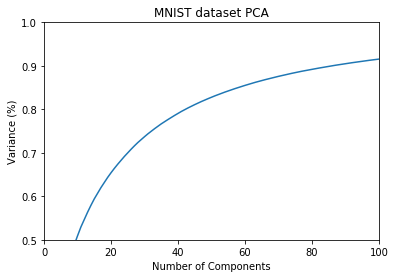

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[0, 1])

data_rescaled = scaler.fit_transform(x_train_b)

pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance 
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('MNIST dataset PCA')
plt.ylim((.5,1))
plt.xlim((0,100))
plt.savefig('MNIST_PCA_less100pc.jpg')
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score,KFold, LeaveOneOut

In [53]:
mnist_pca = PCA(n_components=50) #90% of variability is captured by those PC
mnist_pca.fit(x_train_b)
components = mnist_pca.transform(x_train_b)


In [54]:
loo = LeaveOneOut()
n_splits = loo.get_n_splits(x_train_b,y_train_b)

In [56]:
knn = KNeighborsClassifier(n_neighbors=1,p=11,n_jobs=-1).fit(components,y_train_b)

In [57]:
kf = KFold(n_splits=n_splits,shuffle=True,random_state=1)
cs = cross_val_score(knn,components,y_train_b,cv=kf,n_jobs=-1)

In [61]:
np.mean(cs)

0.9705995099918332

In [14]:

mnist_pca = PCA(n_components=50) #90% of variability is captured by those PC
mnist_pca.fit(x_train_big)
components = mnist_pca.transform(x_train_big)

#test = mnist_pca.transform(x_test)

(59999, 50)

In [13]:
x_train_c = pd.DataFrame(np.ascontiguousarray(x_train.values), columns=x_train.columns)

In [10]:
# mode function
def mode(array):
    '''
    In case of ties we are choosing the value of the nearest neighbor:
    that is because .argmax() return the first item encountered in the array,
    that will be by definition the nearest one
    '''
    val, cnts = np.unique(array, return_counts=True)
    return val[cnts.argmax()], cnts.max()

def manhattan_matrix(X1, X2, p=0):
    return distance.cdist(X1, X2, 'cityblock')

def chebyshev_matrix(X1, X2, p=0):
    return distance.cdist(X1, X2, 'chebyshev')

def mahalanobis_matrix(X1, X2, p=0):
    return distance.cdist(X1, X2, 'mahalanobis', VI=None)

In [ ]:
x_train.values.shape[0]

In [ ]:
dist = np.zeros((x_train.values.shape[0],x_train.values.shape[0]),dtype='float')

In [ ]:
dist.shape

In [2]:
%load_ext Cython

In [5]:
%%cython --annotate


import numpy as np
cimport numpy as np
from cython.parallel import prange,parallel
cimport cython

@cython.profile(False)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.cdivision(True)
cpdef double[:, ::1] dist(double [:, :] A, int k_max,int p): #k: number of max k, 
    '''
    A-> matrix
    k_max -> max number of neighbors
    p-> mikowski distance
    '''

    # declare C types for as many of our variables as possible. note that we
    # don't necessarily need to assign a value to them at declaration time.
    cdef:
        # Py_ssize_t is just a special platform-specific type for indices
        cdef Py_ssize_t n_row = A.shape[0]
        cdef Py_ssize_t n_col = A.shape[1]
        cdef Py_ssize_t i, j, k
        
       
        cdef np.ndarray[np.float64_t, ndim=2] dist_matrix = np.zeros((n_row, n_row), np.double,order='C')
        

        cdef double temp, diff
        
                
                

    # another advantage of using Cython rather than broadcasting is that we can
    # exploit the symmetry of D by only looping over its upper triangle

    for i in prange(n_row,schedule='static',nogil=True):
        for j in xrange(i + 1, n_row): 
            diff = 0
            for k in xrange(n_col):
                temp = (A[i, k] - A[j, k])**p
                diff+=temp
            diff = diff**(1/p)

            dist_matrix[i, j] = diff
            dist_matrix[j, i] = diff

            

    return dist_matrix

TypeError: dist() takes exactly 3 positional arguments (0 given)

In [ ]:
x_train_big = pd.read_csv('MNIST_train.csv',dtype=np.double,).values

In [18]:
%time distances = dist(x_train_c,10,2)
#savetxt('train_dist.csv', distances, delimiter=',')

NameError: name 'dist' is not defined

In [ ]:
from numpy import savetxt
from numpy import loadtxt

In [ ]:
tx= loadtxt('train_dist.csv',delimiter=',')

In [12]:
def imageFilter(data,method):
    '''
    Preprocessing:
    data -> np.array image or datasets of images
    method:
        1. Gaussian:  a Gaussian kernel is used: Gaussian filtering is highly effective in removing Gaussian noise from the image.
        2. Median: median of all the pixels under the kernel window and the central pixel 
        is replaced with this median value.
    
    '''
    if method == 'gaussian':
        return np.apply_along_axis(lambda img: cv2.GaussianBlur(img.astype(dtype=np.uint8).reshape(28,-1),(5,5),0).flatten(),1,data)
    if method =='averaging':
        kernel = np.ones((5,5),np.float32)/25
        return np.apply_along_axis(lambda img: cv2.filter2D(img.astype(dtype=np.uint8).reshape(28,-1),-1,kernel).flatten(),1,data)

In [13]:
# mathematical functions
def mode(array):
    '''
    In case of ties we are choosing the value of the nearest neighbor:
    that is because .argmax() return the first item encountered in the array,
    that will be by definition the nearest one
    '''
    val, cnts = np.unique(array, return_counts=True)
    return val[cnts.argmax()], cnts.max()

def manhattan_matrix(X1, X2, p=0):
    return distance.cdist(X1, X2, 'cityblock')

def chebyshev_matrix(X1, X2, p=0):
    return distance.cdist(X1, X2, 'chebyshev')

def mahalanobis_matrix(X1, X2, p=0):
    return distance.cdist(X1, X2, 'mahalanobis', VI=None)

def cosine_dist(X1, X2, p=0):
    mat = np.dot(np.array(X2).T,np.array(X1))
    return 2 - 2*mat.T

def minkowski_dist(v, w, p = 2):
    D = np.abs(np.subtract(w, v))
    Dp = np.power(D, p)
    distance_vals = np.sum(Dp, axis = 0)
    distance_vals_p = np.power(distance_vals, 1 / p)
    return distance_vals_p

In [14]:

class KNN():

    # Initialization and printing functions
    def __init__(self,  p=2, distance='minkowski', distance_f=minkowski_dist):
        self.p = p
        self.distance_f = distance_f
        if(distance=='manhattan'):
            self.distance = 'manhattan'
            self.distance_matrix = manhattan_matrix
        elif(distance=='chebyshev'):
            self.distance = 'chebyshev'
            self.distance_matrix = chebyshev_matrix
        else:
            self.distance = 'minkowski'
            self.distance_matrix = distance_matrix
        pass

    # fit --> create distance matrix
    def fit(self, X, y, k_max, fast=False, p_array=[2] ):
        """
        Fit on training data

        X: x_train dataset
        Y: y_train
        fast: skip the computation of the pairwise distance matrix
        """
        self.x_train = X
        self.y_train = y
        self.n_training = X.shape[0]
        self.classes = np.unique(y)
        if not fast:
            
            #self.dist_mtx = self.distance_matrix(X, X, p=self.p)
            self.k_neigh_mtx = self.create_k_matrix(k_max)
            
            #only for paolo's version
            self.k_neigh_mtx = self.k_neigh_mtx.reshape(self.k_neigh_mtx.shape[0], self.k_neigh_mtx.shape[1])

        pass

    def __str__(self):
        return 'Knn with distance parameter p = {}'.format(self.p)

    def __repr__(self):
        return self.__str__()

    def loss(self, y1, y2):
        return y1 != y2

    def create_k_matrix(self, k):
        '''
        Reduce the matrix for the cross validation by considering only k smallest values
        k: max value for the neighbor

        '''
        #Mark version
        '''distance_dict = pd.DataFrame()
        for image_inx, image_image in tqdm(self.x_train.iterrows(), total = self.x_train.shape[0], position=0, leave=True):
            image_list_matrix = np.asarray(self.x_train).T
            image_single_matrix = np.asarray(image_image).reshape(self.x_train.shape[1], 1)   
            dist = self.distance_f(image_list_matrix, image_single_matrix)      
            dist_label = np.c_[dist, self.y_train]  # append the training labels: [distance, label]
            dist_label_sort = dist_label[dist_label[:, 0].argsort(kind = 'quicksort')]  # sort the distances
            first_k_labels = dist_label_sort[:k, 1]
            distance_dict[int(image_inx)] = first_k_labels
        return np.array(distance_dict).T
        '''

        #Paolo
        return np.apply_along_axis(lambda x: np.argsort(self.distance_matrix(self.x_train.values, [x], p=self.p), axis=0)[:k],1, self.x_train.values)
        
        #return np.apply_along_axis(lambda x: np.argsort(x)[:k], 1, self.dist_mtx)

    def cross_validate(self, k, n_fold='loocv'):
        """
        k_max : number of maximum to consider
        n_fold : fold of cross validation.
          if n_fold='loocv' it will just use the leave-one-out cross validation where n_fold= # training samples
        """

        if n_fold == 'loocv':
            loss_ipk = [self.predict_train(i, k) for i in range(self.n_training)]
            loss_cv = np.mean(loss_ipk, axis=0)
        return loss_cv
    

    def predict_train(self, i, k):
        
        #Mark
        #y_pred = mode(self.k_neigh_mtx[i, 1:(k+1)])[0]
        
        #Paolo
        y_pred = mode(self.y_train[self.k_neigh_mtx[i, 1:(k+1)]])[0]        
        
        return self.loss(y_pred, self.y_train[i])

    def predict(self, x_test, k_array):
        """
        Predict class for the given observation
        x_test: new observations to predict
        k_array: array of k number of neighbors to consider
        """
        #NOT COMPUTING ENTIRE MATRIX
        kmax_neigh = np.apply_along_axis(
            lambda x: np.argsort(self.distance_matrix(self.x_train.values, [x],  p=self.p), axis=0)[:np.max(k_array)],1, x_test)
        kmax_neigh = np.squeeze(kmax_neigh, axis=2)

        return [np.apply_along_axis(lambda neigh: mode(self.y_train[neigh[:k]])[0], 1, kmax_neigh) for k in k_array]
                
        #COMPUTING ENTIRE MATRIX
        #distances = self.distance_matrix(x_test, self.x_train, p=self.p)
        #neighbors = np.apply_along_axis(lambda x: np.argsort(x), 1, distances)[:, :np.max(k_array)]
        #return [np.apply_along_axis(lambda neigh: mode(self.y_train[neigh[:k]])[0], 1, neighbors) for k in k_array]
        
    def compute_loss(self, x_test, y_test, k_array):
        """
        Score function: predict the values and compare to the real values given
        x_test: input value to predict
        y_test: real value of output
        k_array: array of k number of neihbors to consider
        """
        predictions = self.predict(x_test, k_array)
        losses = [self.loss(predictions[kidx],y_test).sum()/y_test.shape[0] for kidx, k in enumerate(k_array)]
        return dict(zip(k_array, losses))

In [ ]:
#(a)
knn_a = KNN()
knn_a.fit(x_train,y_train, k_max=20)
train_loss = knn_a.score(x_train, y_train, np.arange(1,21))
test_loss = knn_a.score(x_test, y_test, np.aran2ge(1,21))

print("train loss:", np.array([train_loss[k] for k in train_loss]).mean())
print("test loss:", np.array([test_loss[k] for k in test_loss]).mean())

In [ ]:
#plot train_score and test_score
plt.xlabel('K')
plt.ylabel('Empirical loss')
plt.plot(*zip(*sorted(train_loss.items())), label="Train set")
plt.plot(*zip(*sorted(test_loss.items())), label="Test set")
plt.legend()
plt.show()

In [ ]:
#(b)
knn_b = KNN()
knn_b.fit(x_train,y_train, k_max=20) 
k_array = np.arange(1,21)
train_loss = dict(zip(k_array, [knn_b.cross_validate(k) for k in k_array]))
test_loss = knn_b.compute_loss(x_test, y_test, np.arange(1,21)) # We don't need to recompute it (computed in (a))

In [ ]:
test_loss = knn_b.compute_loss(x_test, y_test, np.arange(1,21)) # We don't need to recompute it (computed in (a))

In [ ]:
print("train loss:", np.array([train_loss[k] for k in train_loss]).mean())
print("test loss:", np.array([test_loss[k] for k in test_loss]).mean())

In [ ]:
#plot train_score_crossVal and test_score
plt.xlabel('K')
plt.ylabel('Empirical loss')
plt.plot(*zip(*sorted(train_loss.items())), label="Train set")
plt.plot(*zip(*sorted(test_loss.items())), label="Test set")
plt.legend()
plt.show()

In [ ]:
#(c)
crossValScore = []
for p in np.arange(1,16):
    knn_c = KNN(p=p)
    knn_c.fit(x_train,y_train, k_max=20)
    k_array = np.arange(1,21)
    crossValScore.append(dict(zip(k_array, [knn_c.cross_validate(k) for k in k_array])))
crossValScore = pd.DataFrame(crossValScore)
    

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))  
sns.heatmap(crossValScore, ax=ax, xticklabels=np.arange(1,21), yticklabels=np.arange(1,16))

In [ ]:
knn_d_euclidean = KNN()
knn_d_euclidean.fit(x_train, y_train, k_max=20)
k_array = np.arange(2,21)
crossValScore_euclidean = dict(zip(k_array, [knn_d_euclidean.cross_validate(k) for k in k_array]))

knn_d_manhattan = KNN(distance='manhattan')
knn_d_manhattan.fit(x_train, y_train, k_max=20)
k_array = np.arange(2,21)
crossValScore_manhattan = dict(zip(k_array, [knn_d_manhattan.cross_validate(k) for k in k_array]))

knn_d_chebyshev = KNN(distance='chebyshev')
knn_d_chebyshev.fit(x_train, y_train, k_max=20)
k_array = np.arange(2,21)
crossValScore_chebyshev = dict(zip(k_array, [knn_d_chebyshev.cross_validate(k) for k in k_array]))


In [ ]:
df = pd.DataFrame([crossValScore_euclidean, crossValScore_manhattan, crossValScore_chebyshev])

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(13, 4))
sns.heatmap(df, annot=True, linewidths=.5, ax=ax,
            yticklabels=['euclidean', 'manhattan', 'chebyshev'])

## Preprocessing with different filters


In [24]:
import cv2

In [25]:

train_gaussian = pd.DataFrame(imageFilter(x_train_n,'gaussian'))
train_averaging = pd.DataFrame(imageFilter(x_train_n,'averaging'))


In [15]:
knn = KNN(p=11)
k_array = np.arange(1,21)

x_train_n = pd.DataFrame(MinMaxScaler().fit_transform(x_train))

start = time.time()
knn.fit(x_train_n, y_train, k_max=20)
norm_score = dict(zip(k_array, [knn.cross_validate(k) for k in k_array]))
print('Normalized data:',time.time()-start)


start = time.time()
knn.fit(x_train, y_train, k_max=20)
score = dict(zip(k_array, [knn.cross_validate(k) for k in k_array]))
print('Not normalized  data:',time.time()-start)

Normalized data: 820.6088969707489
Not normalized  data: 166.13432693481445


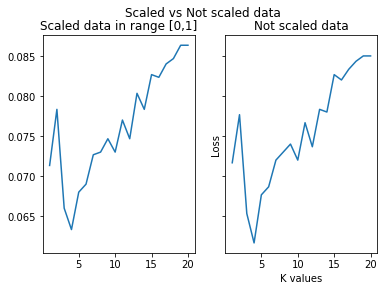

In [21]:

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharey=True)
ax1.set_title('Scaled data in range [0,1]')
ax1.plot(*zip(*sorted(norm_score.items())), label="Normalization")

ax2.set_title('Not scaled data')
ax2.plot(*zip(*sorted(score.items())), label="default data values")

plt.xlabel('K values')
plt.ylabel('Loss')
fig.suptitle('Scaled vs Not scaled data ')
plt.savefig('scaledvsnot.jpg')
plt.show()

In [138]:
knn = KNN(p=11)
k_array = np.arange(2,21)

start = time.time()
knn.fit(train_gaussian, y_train, k_max=20)
score_gaussian = dict(zip(k_array, [knn.cross_validate(k) for k in k_array]))
print('GaussianBlurring preprocessing:',time.time()-start)


start = time.time()
knn.fit(train_averaging, y_train, k_max=20)
score_median = dict(zip(k_array, [knn.cross_validate(k) for k in k_array]))
print('Averaging kernel preprocessing:',time.time()-start)

start = time.time()
knn.fit(x_train, y_train, k_max=20)
score_normal = dict(zip(k_array, [knn.cross_validate(k) for k in k_array]))
print('No preprocessing:',time.time()-start)


GaussianBlurring preprocessing: 116.57270216941833
Averaging kernel preprocessing: 127.65520691871643
No preprocessing: 152.90850019454956


from skimage.color import rgb2gray
img = x_train.iloc[0].to_numpy().reshape(28,-1)


img =  img[:,:,np.newaxis]
img.reshape(28,28,3)

In [58]:
from skimage.color import rgb2gray
img = x_train.iloc[0].to_numpy().reshape(28,-1)
#
np.atleast_3d(img).shape


(28, 28, 1)

In [51]:
rgb2gray(img)

ValueError: the input array must be have a shape == (.., ..,[ ..,] 3)), got (28, 28, 1)

In [129]:
from sklearn.preprocessing import Normalizer

In [140]:
score_gaussian

{2: 0.8899633211070357,
 3: 0.8899633211070357,
 4: 0.8936312104034678,
 5: 0.8936312104034678,
 6: 0.8936312104034678,
 7: 0.8936312104034678,
 8: 0.8899633211070357,
 9: 0.8899633211070357,
 10: 0.8899633211070357,
 11: 0.8826275425141714,
 12: 0.8922974324774925,
 13: 0.8922974324774925,
 14: 0.8922974324774925,
 15: 0.8936312104034678,
 16: 0.8936312104034678,
 17: 0.8936312104034678,
 18: 0.8936312104034678,
 19: 0.8936312104034678,
 20: 0.8936312104034678}

NameError: name 'score_gaussian' is not defined

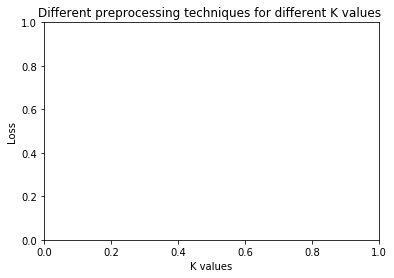

In [22]:
#plot train_score and test_score
plt.title('Different preprocessing techniques for different K values ')
plt.xlabel('K values')
plt.ylabel('Loss')
plt.plot(*zip(*sorted(score_gaussian.items())), label="GaussianBlurring")
plt.plot(*zip(*sorted(score_median.items())), label="Averaging Kernel")
plt.plot(*zip(*sorted(score_normal.items())), label="No preprocessing")
plt.legend()
plt.savefig('preprocessing_image.jpg')
plt.show()

In [120]:
score_normal

0.08502834278092697

In [96]:
x_train[y_train == 8].index[0]

6

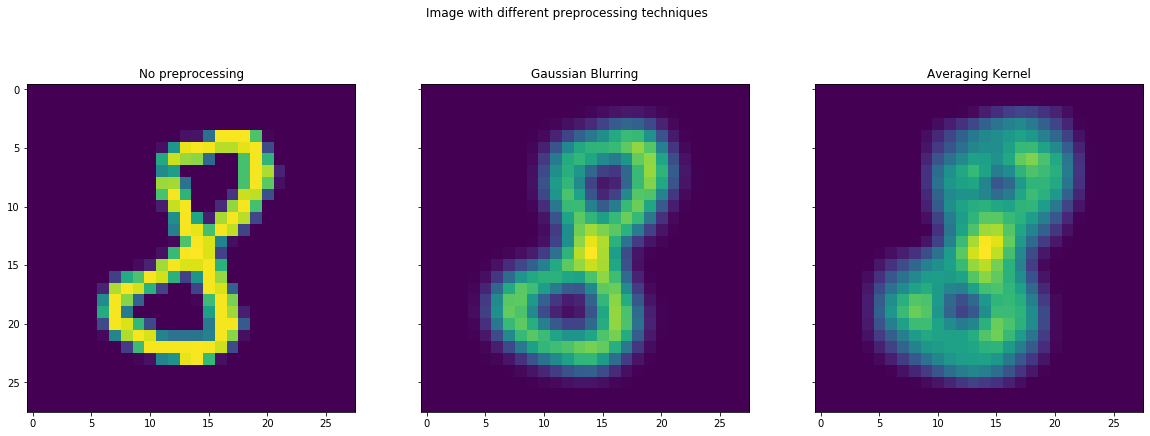

In [110]:
#find index where value is equal to 8
idx_img = x_train[y_train == 8].index[0]

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(20,7),squeeze=True)

ax1.set_title('No preprocessing')
ax1.imshow(x_train.iloc[6].to_numpy().reshape(28,-1));


ax2.set_title('Gaussian Blurring')
ax2.imshow(train_gaussian.iloc[6].to_numpy().reshape(28,-1));

ax3.set_title('Averaging Kernel')
ax3.imshow(train_averaging.iloc[6].to_numpy().reshape(28,-1));

fig.suptitle('Image with different preprocessing techniques')

plt.savefig('print_number_prepr.jpg')
plt.show()




PCA


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(x_train)

pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance 
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.ylim((0.9,1))
plt.show()

##--> n = 200/400 components express 95/99 % of the variance => 300 are chosen

In [ ]:

mnist_pca = PCA(n_components=0.90) #90% of variability is captured by those PC
mnist_pca.fit(x_train)
components = mnist_pca.transform(x_train)

test = mnist_pca.transform(x_test)

In [ ]:
knn_pca = KNN()

start = time.time()
knn_pca.fit(components,y_train,k_max=20)
print(time.time()-start)

train_score = knn_pca.score(components, y_train, np.arange(1,21))
print("train score:", np.array([train_score[k] for k in train_score]).max())

test_score = knn_pca.score(test, y_test, np.arange(1,21))
print("test score:", np.array([test_score[k] for k in test_score]).max())


In [ ]:
projected = mnist_pca.inverse_transform(components)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(projected[0,:].reshape(28,-1))
ax1.set_title('PCA transformation')
ax2.imshow(x_train.values[0,:].reshape(28,-1))
ax2.set_title('Original Image')